In [1]:
!pip install ../input/frufs-python-package/FRUFS-1.0.2-py3-none-any.whl
#!pip install PyImpetus

Processing /kaggle/input/frufs-python-package/FRUFS-1.0.2-py3-none-any.whl


In [2]:
import os
import shutil
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

from FRUFS import FRUFS
#from PyImpetus import PPIMBC
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder, LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from catboost import Pool, CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb

import pickle
import json

In [3]:
with open('../input/brats2021-radiomics-features/training_radiomics_features.json', 'r') as f:
     train_features = json.load(f)

with open('../input/brats2021-radiomics-features/validation_radiomics_features.json', 'r') as f:
     test_features = json.load(f)

with open('../input/brats2021-radiomics-features/column_names.pkl', 'rb') as f:
    column_names = pickle.load(f)
    
train_labels_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
test_labels_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

In [4]:
t1 = train_features["t1"]["multi"]["504"]
flair = train_features["flair"]["multi"]["504"]

diff = [t1[i]-flair[i] for i in range(len(t1))]

diff_cols_modality = []
for i in range(len(t1)):
    if diff[i] != 0:
        diff_cols_modality.append(column_names[i])
        
print(f"Varying features wrto Modality: {len(diff_cols_modality)} \n\n {diff_cols_modality}")

Varying features wrto Modality: 17 

 ['diagnostics_Image-original_Mean', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Variance']


In [5]:
t1 = train_features["t1"]["4"]["504"]
flair = train_features["t1"]["2"]["504"]

diff = [t1[i]-flair[i] for i in range(len(t1))]

diff_cols_seg = []
for i in range(len(t1)):
    if diff[i] != 0:
        diff_cols_seg.append(column_names[i])
        
print(f"Varying features wrto Segmentation Label: {len(diff_cols_seg)} \n\n {diff_cols_seg}\n\n")

Varying features wrto Segmentation Label: 71 

 ['diagnostics_Mask-original_BoundingBox_0', 'diagnostics_Mask-original_BoundingBox_1', 'diagnostics_Mask-original_BoundingBox_2', 'diagnostics_Mask-original_BoundingBox_3', 'diagnostics_Mask-original_BoundingBox_4', 'diagnostics_Mask-original_BoundingBox_5', 'diagnostics_Mask-original_CenterOfMassIndex_0', 'diagnostics_Mask-original_CenterOfMassIndex_1', 'diagnostics_Mask-original_CenterOfMassIndex_2', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'or

In [6]:
## Final Column Names

final_col_names = ["BraTS21ID"]

for modality in ["t1", "t2", "t1ce", "flair"]:
    for seg in ["multi", "1", "2", "4"]:
        for col in column_names[1:]:
            final_col_names.append("_".join([modality,seg,col]))

In [7]:
## Function to make DataFrame of features
def clean_features(features, clf_df):
    id_ls = list(features["t1"]["multi"].keys())
    rad_features = []  
    for id_ in tqdm(id_ls):
        tmp_features = [int(id_.split("_")[-1])]
        try:
            for modality in ["t1", "t2", "t1ce", "flair"]:
                for seg in ["multi", "1", "2", "4"]:
                    tmp_features.extend(features[modality][seg][id_][1:])
            rad_features.append(tmp_features)
        except Exception as e:
            continue
            
    rad_df = pd.DataFrame(rad_features)
    rad_df.columns = final_col_names
    rad_df = rad_df.T.drop_duplicates().T
    
    rad_features = np.array(rad_df)
    
    seg_ids = [i[0] for i in rad_features]
    clf_ids = list(clf_df["BraTS21ID"])
    inter_ids = list(set(seg_ids) & set(clf_ids))
    
    print(f"Segmentation Ids : {len(seg_ids)}, Classification Ids: {len(clf_ids)}, Intersection Ids: {len(inter_ids)}")
    
    final_df = pd.DataFrame(rad_features, columns=list(rad_df.columns))
    final_df = final_df[final_df["BraTS21ID"].isin(inter_ids)]
    final_df = final_df.sort_values(by="BraTS21ID")
    
    clf_df = clf_df[clf_df["BraTS21ID"].isin(inter_ids)]
    
    final_df = pd.merge(final_df,clf_df,on="BraTS21ID")
    
    for col in list(rad_df.columns):
        dtype = final_df[col].dtype
        if dtype == "object":
            final_df[col] = final_df[col].astype(float)
    
    final_df["BraTS21ID"] = final_df["BraTS21ID"].astype(int)
    return final_df

In [8]:
## Training and Testing Radiomics Features
train_df = clean_features(train_features, train_labels_df)
test_df = clean_features(test_features, test_labels_df)

train_df = train_df[list(test_df.columns)]

100%|██████████| 1251/1251 [00:00<00:00, 27585.55it/s]


Segmentation Ids : 1170, Classification Ids: 585, Intersection Ids: 555


100%|██████████| 219/219 [00:00<00:00, 45421.18it/s]

Segmentation Ids : 210, Classification Ids: 87, Intersection Ids: 84


## Feature Selection

In [9]:
### FRUFS
cols = list(train_df.columns)[1:-1]

model_frufs_generated = FRUFS(
        model_r=lgb.LGBMRegressor(random_state=42),
        k=15
    )

train_feature_cols = model_frufs_generated.fit_transform(train_df[cols])
test_feature_cols = model_frufs_generated.transform(test_df[cols])

Progress bar: 100%|██████████| 425/425 [04:54<00:00,  1.44it/s]


In [10]:
# plt.figure(figsize=(10,100))
# model_frufs_generated.feature_importance()

In [11]:
# ## Correlation

# corr_cols = []
# cols = list(test_df.columns)[1:-1]
# label_col = list(test_df.columns)[-1]

# for col in tqdm(cols):
#     corr = train_df[col].corr(train_df[label_col])
#     if corr>0.1 or corr<-0.1:   
#         corr_cols.append(col)
        
# id_col = ["BraTS21ID"]
# label_col = ["MGMT_value"]
# final_cols = id_col+corr_cols+label_col

# train_df = train_df[final_cols]
# test_df = test_df[final_cols]

## Preprocessing

In [12]:
encoders = {}
na_vals_dict = {}

def preprocess_df(df, cat_features, cont_features, data = "train"):
    for col in cat_features:
        if data == "train":
            na_val = df[col].value_counts().idxmax()
            df[col].fillna(na_val,inplace=True)
            cat_encoder = LabelEncoder()
            df[col] = cat_encoder.fit_transform(np.array(df[col]).reshape(-1, 1))
            encoders[col] = cat_encoder
            na_vals_dict[col] = na_val
        else:
            df[col].fillna(na_vals_dict[col],inplace=True)
            df[col] = encoders[col].transform(np.array(df[col]).reshape(-1, 1))
    
            
    for col in cont_features: 
        if data == "train":
            na_val = np.mean(df[col])
            df[col].fillna(na_val,inplace=True)
            cont_encoder = MinMaxScaler() #StandardScaler()
            df[col] = cont_encoder.fit_transform(np.array(df[col]).reshape(-1, 1))
            encoders[col] = cont_encoder
            na_vals_dict[col] = na_val
        else:
            df[col].fillna(na_vals_dict[col],inplace=True)
            df[col] = encoders[col].transform(np.array(df[col]).reshape(-1, 1))

    return df

In [13]:
SEED = 143

feature_cols = list(train_feature_cols.columns)
#list(test_df.columns)[1:-1] #list(train_feature_cols.columns)
label_col = ["MGMT_value"]
id_col = ["BraTS21ID"]
final_cols = id_col + feature_cols + label_col

train_df = train_df[final_cols]
train_df[feature_cols] = train_feature_cols

test_df = test_df[final_cols]
test_df[feature_cols] = test_feature_cols

train_df = preprocess_df(train_df, [], feature_cols, data = "train")
test_df = preprocess_df(test_df, [], feature_cols, data = "test")

train_labels = np.array(train_df["MGMT_value"])
train_ds = train_df.drop(["MGMT_value", "BraTS21ID"], axis = 1).reset_index(drop=True)

test_labels = np.array(test_df["MGMT_value"])
test_ds = test_df.drop(["MGMT_value", "BraTS21ID"], axis = 1).reset_index(drop=True)

In [14]:
# ### Sklearn Feature Selection
# feature_cols = list(train_ds.columns)
# kbest = SelectKBest(chi2, k=15) #chi2 f_classif
# train_ds = kbest.fit_transform(train_ds, train_labels)
# test_ds = kbest.transform(test_ds)

# cols = kbest.get_feature_names_out(feature_cols)

# train_ds = pd.DataFrame(train_ds, columns=cols)
# test_ds = pd.DataFrame(test_ds, columns=cols)

In [15]:
# ### PCA Feature Selection

# pca = PCA(n_components=150)

# train_ds = pca.fit_transform(train_ds)
# test_ds = pca.transform(test_ds)

# train_ds = pd.DataFrame(train_ds)
# test_ds = pd.DataFrame(test_ds)

In [16]:
# ### VIF Feature selection

# vif = pd.Series([variance_inflation_factor(train_ds.values, i) for i in range(train_ds.shape[1])], index=train_ds.columns)
# index = train_ds.columns.tolist()
# cols_df = pd.DataFrame(vif, index = index, columns = ['vif']).sort_values(by = 'vif', ascending=False)
# cols_df[cols_df['vif']<10]
# cols = list(cols_df.index)

# train_ds = train_ds[cols]
# test_ds = test_ds[cols]

In [17]:
# ### PyImpetus Feature Selection
# model = LGBMClassifier(
#                n_estimators = 1000,
#                metric = "auc"
#     )

# pyimp = PPIMBC(model=model, p_val_thresh=0.05, num_simul=5, simul_size=0.2, simul_type=0, sig_test_type="non-parametric", cv=5, random_state=SEED, n_jobs=-1, verbose=2)

# train_ds = pyimp.fit_transform(train_ds, train_labels)
# test_ds = pyimp.transform(test_ds)

In [18]:
def auroc(y_pred, y_true):
    y_true = y_true.get_label()
    length = len(y_true)
    
    return 'roc_auc', roc_auc_score(y_true, y_pred, average="macro"), True

In [19]:
###########
## Training
###########
N_SPLITS = 7

kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

test_preds = 0
feature_imp = 0
mean_val = 0

for i, (train_idx,val_idx) in enumerate(kfold.split(train_ds,train_labels)):
    print('\n\n--------------------- Running {} of KFold {}-------------------------'.format(i+1,kfold.n_splits))
    xtr,xvl = train_ds.loc[train_idx],train_ds.loc[val_idx]
    ytr,yvl = train_labels[train_idx],train_labels[val_idx]
    
#     model = CatBoostClassifier(
#                         verbose=50,
#                         eval_metric="AUC",
#                         loss_function="Logloss",
#                         random_state=2021,
#                         num_boost_round=100,
#                         od_type="Iter",
#                         od_wait=200,
#                         cat_features=None,
#                         bagging_temperature=1.288692494969795,
#                         grow_policy="Depthwise",
#                         l2_leaf_reg=9.847870133539244,
#                         learning_rate=0.01877982653902465,
#                         max_depth=8,
#                         min_data_in_leaf=1,
#                         penalties_coefficient=2.1176668909602734,
#             )
#     model.fit(xtr,ytr,eval_set=(xvl,yvl))
    
    params = {
        'objective': 'cross_entropy',
        #'boosting': 'dart',
        'seed': SEED,
        'num_iterations' : 1000,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40,
        'device_type' : "cpu",
        #'num_classes': 2,
        'eval_metric' : 'auc',
        'verbose' : -1
        }
    
    lgb_train = lgb.Dataset(xtr, ytr) 
    lgb_valid = lgb.Dataset(xvl, yvl)
    model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 1000,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 200,
            verbose_eval=200,
            feval = auroc
            )

#     model = XGBClassifier(
#                use_label_encoder = False,
#                eval_metric = "auc"
#     )
#     model.fit(xtr,ytr,eval_set=[(xvl,yvl)], verbose = 500)
    
    #model = LogisticRegression(random_state=SEED)
    #model = SVC(random_state=SEED)
    #model = RandomForestClassifier(random_state=SEED)
    #model = HistGradientBoostingClassifier(random_state=SEED)
    #model.fit(xtr, ytr)
    test_preds += model.predict(test_ds)
    
    val_preds = model.predict(xvl)
    val_rocauc = roc_auc_score(yvl,val_preds, average="macro")
    mean_val += val_rocauc
    print(f"Val Predictions: {np.bincount([np.max(i) for i in val_preds])}")
    print("\nValidation Dataset - ROC AUC Score = {}".format(val_rocauc))
    
    feature_imp += model.feature_importance()  #.feature_importance() #feature_importances_


test_preds = test_preds/N_SPLITS
#feature_imp = list(feature_imp/N_SPLITS)
mean_val = mean_val / N_SPLITS

print(f"Mean Val ROC AUC: {mean_val}")



--------------------- Running 1 of KFold 7-------------------------
Training until validation scores don't improve for 200 rounds
[200]	training's cross_entropy: 0.637454	training's roc_auc: 0.812089	valid_1's cross_entropy: 0.695106	valid_1's roc_auc: 0.496867
Early stopping, best iteration is:
[6]	training's cross_entropy: 0.689326	training's roc_auc: 0.678773	valid_1's cross_entropy: 0.691153	valid_1's roc_auc: 0.565476
Val Predictions: [80]

Validation Dataset - ROC AUC Score = 0.5654761904761906


--------------------- Running 2 of KFold 7-------------------------
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 200 rounds
[200]	training's cross_entropy: 0.641956	training's roc_auc: 0.812409	valid_1's cross_entropy: 0.681486	valid_1's roc_auc: 0.566416
[400]	training's cross_entropy: 0.603799	training's roc_auc: 0.833938	valid_1's cross_entropy: 0.671531	valid_1's roc_auc: 0.597118
[600]	training's cross_entropy: 0.575122	tra

(array([ 1.,  1.,  4.,  8., 15., 17., 11., 15.,  9.,  3.]),
 array([0.46129104, 0.47247934, 0.48366765, 0.49485596, 0.50604426,
        0.51723257, 0.52842088, 0.53960918, 0.55079749, 0.5619858 ,
        0.5731741 ]),
 <BarContainer object of 10 artists>)

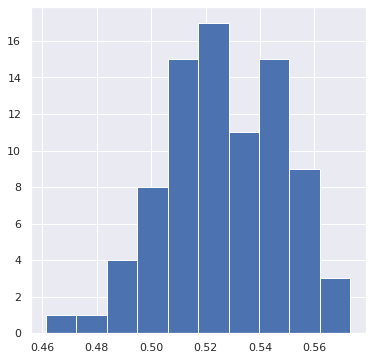

In [20]:
probs = [i for i in test_preds]

plt.figure(figsize = (6,6))
plt.hist(probs)

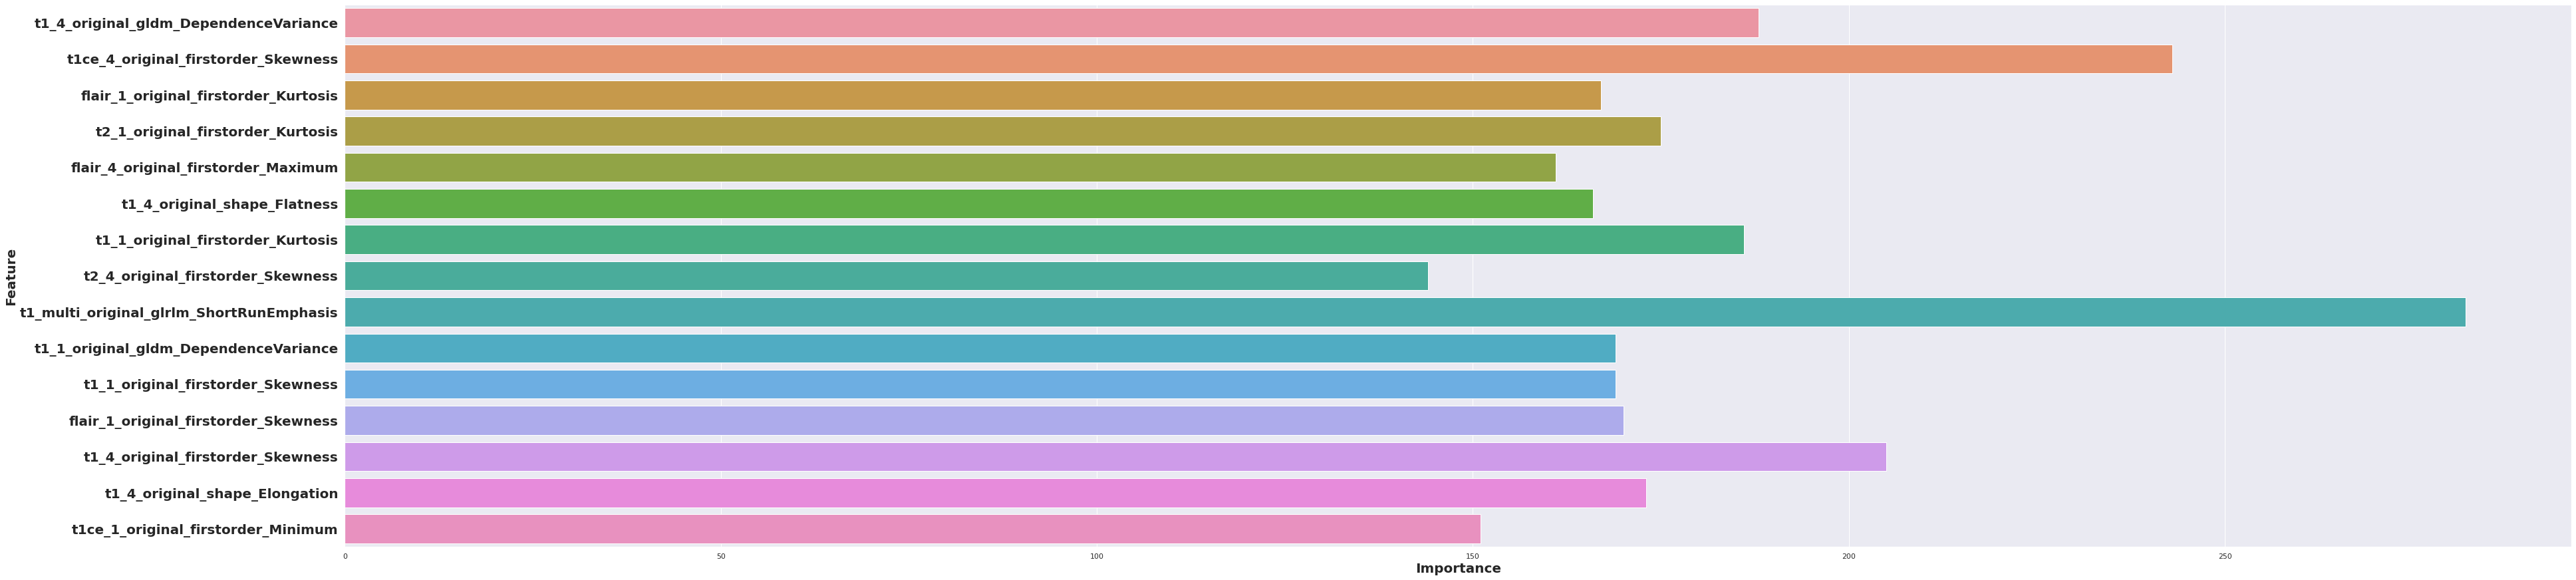

In [21]:
#Feature Importances

imp_df = pd.DataFrame.from_dict({
    "Feature": list(test_ds.columns),
    "Importance": feature_imp
})
#imp_df.to_csv("./Feature_Importance.csv", index=False)

fig, ax = plt.subplots(figsize = (60,15))
#plt.bar(list(train_ds.columns),feature_imp)
sns.barplot(data=imp_df, x="Importance", y="Feature", ax=ax)
#plt.title("Feature Importance")
plt.ylabel("Feature", weight="bold", size=20)
plt.yticks(weight="bold", size=20)
plt.xlabel("Importance", weight="bold", size=20)
plt.show()
#fig.savefig("./feature_importance.png")

In [22]:
sort_ids = np.argsort(feature_imp)[::-1]
cols = list(train_df.columns)[1:-1]
for i in range(5):
    print(cols[sort_ids[i]], feature_imp[sort_ids[i]])

t1_multi_original_glrlm_ShortRunEmphasis 282
t1ce_4_original_firstorder_Skewness 243
t1_4_original_firstorder_Skewness 205
t1_4_original_gldm_DependenceVariance 188
t1_1_original_firstorder_Kurtosis 186


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 555 samples in 0.000s...
[t-SNE] Computed neighbors for 555 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 555 / 555
[t-SNE] Mean sigma: 0.175726
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.045036
[t-SNE] KL divergence after 300 iterations: 0.958903


Text(0.5, 1.0, 'tSNE of PyRadiomice Features')

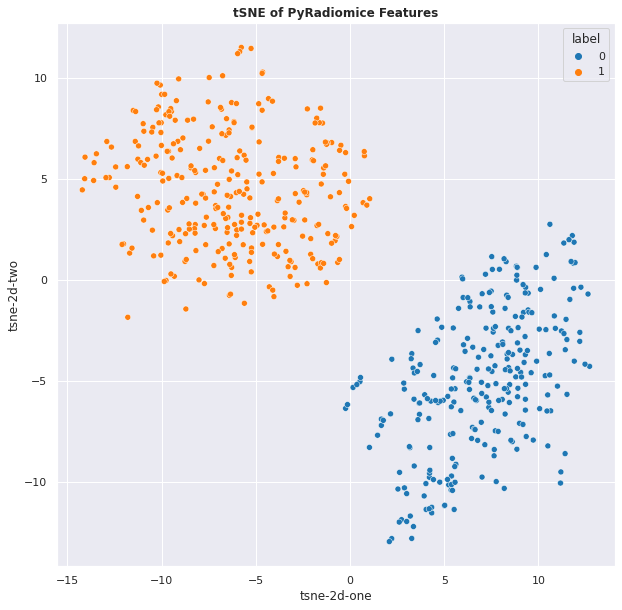

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE()

tsne_df = train_df.drop("BraTS21ID", axis=1)
tsne_embeds = np.array(tsne_df)
tsne_labels = train_labels

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
scatter = tsne.fit_transform(tsne_embeds)

df_tmp = pd.DataFrame.from_dict({
    "tsne-2d-one" : scatter[:,0],
    "tsne-2d-two" : scatter[:,1],
    "label" : tsne_labels
})
df_tmp['tsne-2d-one'] = scatter[:,0]
df_tmp['tsne-2d-two'] = scatter[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    data=df_tmp,
    palette = sns.color_palette("tab10", 2),
    legend="full",
)
plt.title("tSNE of PyRadiomice Features", weight="bold")
#plt.savefig("./tsne_featureselection.png")

## Submission

In [24]:
df_tmp = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

sub_df = pd.DataFrame.from_dict({
    "BraTS21ID": test_df["BraTS21ID"],
    "MGMT_value": probs
})

orig_ids = list(df_tmp["BraTS21ID"])
act_ls = list(test_df["BraTS21ID"])

for i in orig_ids:
    if i not in act_ls:
        sub_df.loc[len(sub_df.index)] = [i, 0.5]
        
sub_df = sub_df.sort_values(by="BraTS21ID")
sub_df["BraTS21ID"] = sub_df["BraTS21ID"].astype(int)

sub_df.to_csv("./submission.csv", index=False)

sub_df.head()

,BraTS21ID,MGMT_value
0,1,0.508338
1,13,0.552047
2,15,0.573174
3,27,0.532276
4,37,0.521722


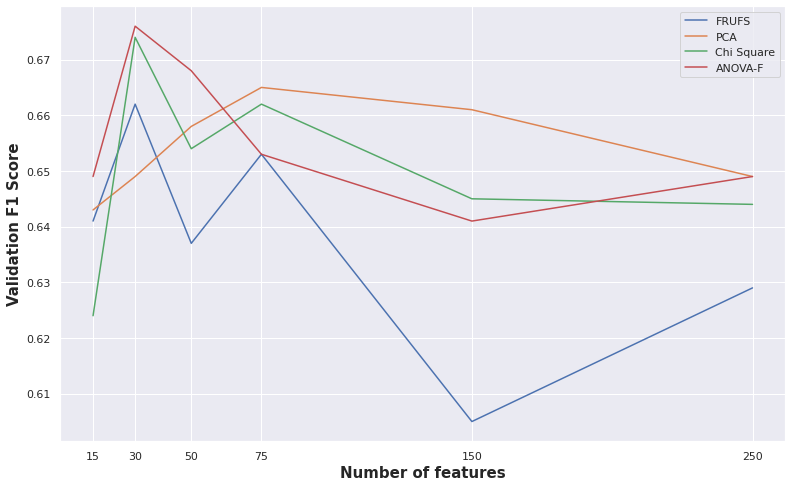

In [25]:
legends = ["FRUFS", "PCA", "Chi Square", "ANOVA-F"]

scores = [
    [0.641, 0.662, 0.637, 0.653, 0.605, 0.629],
    [0.643, 0.649, 0.658, 0.665, 0.661, 0.649],
    [0.624, 0.674, 0.654, 0.662, 0.645, 0.644],
    [0.649, 0.676, 0.668, 0.653, 0.641, 0.649]
]
k = [15, 30, 50, 75, 150, 250]

plt.figure(figsize = (13,8))

for i in range(len(legends)):
    plt.plot(k, scores[i], label=legends[i])
    
plt.xlabel("Number of features", size=15, weight="bold")
plt.ylabel("Validation F1 Score", size=15, weight="bold")
plt.xticks(k)
plt.legend()
#plt.savefig("./quantitative.png")